In [1]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
LEARNING_RATE = 0.01
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42
BATCH_SIZE = 320

In [8]:
# # use validation year: change path
# X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
# y=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

# X = torch.from_numpy(X).type(torch.float)
# y = torch.from_numpy(y).type(torch.float)

# X_train, X_test, y_train, y_test = train_test_split(X,
#     y,
#     test_size=0.2,
#     random_state=RANDOM_SEED
# )

# use all 8 years: change path
X_train=np.load('/work/sds-lab/Shuochen/climsim/train_input.npy')
y_train=np.load('/work/sds-lab/Shuochen/climsim/train_target.npy')
X_test=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
y_test=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

In [9]:
# # split datasets to training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# create datasets
training_set = TensorDataset(X_train, y_train)
testing_set = TensorDataset(X_test, y_test)
# create dataloaders
train_dataloader = DataLoader(training_set, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)
test_dataloader = DataLoader(testing_set,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [10]:
class MLP(nn.Module):
    def __init__(self, IN_FEATURES, OUT_FEATURES):
        super().__init__()
        self.seq = nn.Sequential(nn.Linear(IN_FEATURES, 768),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(768, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 512),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(512, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 128),
                                 nn.LeakyReLU(0.15))
        self.linear1 = nn.Linear(128, 120)
        self.linear2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()

    def forward(self, x):
        a = self.linear1(self.seq(x))
        b = self.relu(self.linear2(self.seq(x)))
        return torch.concat((a, b), dim=1)
        
model = MLP(IN_FEATURES, OUT_FEATURES).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(),lr=LEARNING_RATE)

In [12]:
print(model)

MLP(
  (seq): Sequential(
    (0): Linear(in_features=124, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.15)
    (2): Linear(in_features=768, out_features=640, bias=True)
    (3): LeakyReLU(negative_slope=0.15)
    (4): Linear(in_features=640, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.15)
    (6): Linear(in_features=512, out_features=640, bias=True)
    (7): LeakyReLU(negative_slope=0.15)
    (8): Linear(in_features=640, out_features=640, bias=True)
    (9): LeakyReLU(negative_slope=0.15)
    (10): Linear(in_features=640, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.15)
  )
  (linear1): Linear(in_features=128, out_features=120, bias=True)
  (linear2): Linear(in_features=128, out_features=8, bias=True)
  (relu): ReLU()
)


In [7]:
torch.manual_seed(42)
epochs = 5

for epoch in range(epochs):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X.to(device))
        loss = loss_fn(y_pred, y.to(device))
        train_loss += loss # accumulatively add up the loss per epoch 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    with torch.inference_mode():
        test_loss = 0
        model.eval()
        for X, y in test_dataloader:
            test_pred = model(X.to(device))
            test_loss += loss_fn(test_pred, y.to(device)) # accumulatively add up the loss per epoch
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 404199607107584.00000 | Test loss: 222663950336.00000
Epoch: 1 | Train loss: 2080021522939904.00000 | Test loss: 34228109312.00000
Epoch: 2 | Train loss: 6801238016393216.00000 | Test loss: 3178387996672.00000
Epoch: 3 | Train loss: 15369069096075264.00000 | Test loss: 11779686006784.00000
Epoch: 4 | Train loss: 859653743312896.00000 | Test loss: 828755607552.00000


In [8]:
# combine batches
model = model.to('cpu')
test_pred = model(X_test)
test_pred = test_pred.detach().numpy()

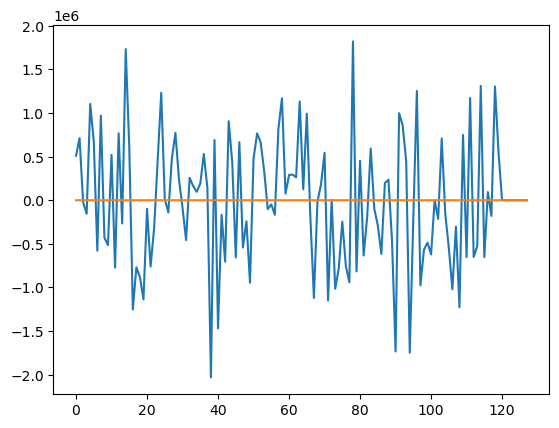

In [9]:
# plot the first sample. Delete this if not necessary.
plt.plot(test_pred[0,:])
plt.plot(y_test[0,:])

# to do: post-processing (metric files)